<a href="https://colab.research.google.com/github/kimwei/colabs/blob/main/micro_grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mircro grad
- following Andrej Karparthy's video: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

In [2]:
#@title Imports
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#@title Implementation of Value class
class Value:
  def __init__(self, data, children=(), _op="", label=""):
    self.data=data
    self._prev=children
    self._op=_op
    self.label=label
    # Grad = 0 means the value at init is not affecting the loss
    self.grad=0.0
    self._backward = lambda: None

  def __repr__(self) -> str:
    return f"Value=(data={self.data}, op={self._op}, label={self.label})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, children=(self, other), _op="+")

    def _backward():
      """Back prop for + operator with chain rule

      L = a + b
      dL/da = 1, dL/db = 1
      '+' operator's derivative is 1.0, the intuitive meaning is that
      it only passes passes the value(derivative) through it without modifying
      the value.
      """
      # BUGGY code: this only fixes the case when the same node is used in
      # multiple times by a graph for + op, the general solution should be,
      # according to multi-variable chain rule, to always accumalate derivatives
      # if self != other:
      #   self.grad = 1.0 * out.grad
      #   other.grad = 1.0 * out.grad
      # else:
      #   self.grad = 2.0 * out.grad
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    """handles 'other + self' case where other is not a instance of Value class.
    """
    return self.__add__(other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, children=(self, other), _op="*")

    def _backward():
      """Backprop for * operator with chain rule

      L = a*b
      dL/da = b, dL/db = a
      """
      # NOTE += accumalates gradient on top of existing ones, this is IMPORTANT
      # when a node is used multiple times in a graph!
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    """handles 'other * self' case where other is not a instance of Value class.
    """
    return self * other

  def __pow__(self, other):
    assert(isinstance(other, (int, float))), "only support int/float for now"
    out = Value(math.pow(self.data, other), children=(self,), _op=f"pow{other}")

    def _backward():
      self.grad += other * math.pow(self.data, other-1) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    """Reuse the impl of * op since a/b -> a * b**(-1)"""
    return self *(other**-1)

  def __sub__(self, other):
    """Reuse + op and * op"""
    return self + (other * -1)

  def tanh(self):
    numerator = math.exp(2 * self.data) - 1
    denominator = math.exp(2 * self.data) + 1
    out = Value(numerator / denominator, children=(self, ), _op="tanh")

    def _backward():
      """Backprop for tanh operator with chain rule"""
      self.grad += (1 - out.data ** 2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    out = Value(math.exp(self.data), children=(self,), _op="exp")

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    """Call backwardprop from current node all the way to leaf nodes using
    topological sort.
    """

    topo = []
    visited = set()
    def _build_nodes(node):
      if node in visited:
        return

      visited.add(node)
      for each in node._prev:
        _build_nodes(each)
      topo.append(node)

    _build_nodes(self)

    self.grad = 1.0
    for each in reversed(topo):
      each._backward()

v = Value(1.0)
v.tanh()

Value=(data=0.7615941559557649, op=tanh, label=)

In [4]:
#@title Test Value's sum op
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = a + b
c.label="c"
d = Value(7.5, label="d")
L = c + d
L.label="L"
L

Value=(data=6.5, op=+, label=L)

In [5]:
#@title Draw graph algo impl
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph"""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:

      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

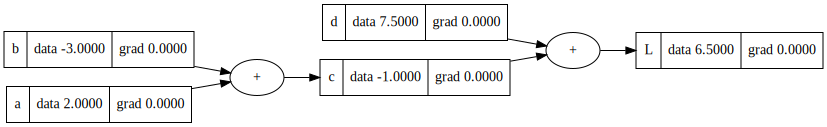

In [6]:
draw_dot(L)

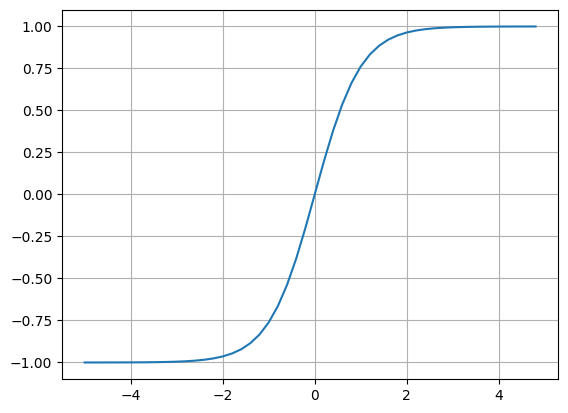

In [7]:
#@title plot the tanh graph
plt.plot(np.arange(-5.0, 5.0, 0.2), np.tanh(np.arange(-5.0, 5.0, 0.2)))
plt.grid()

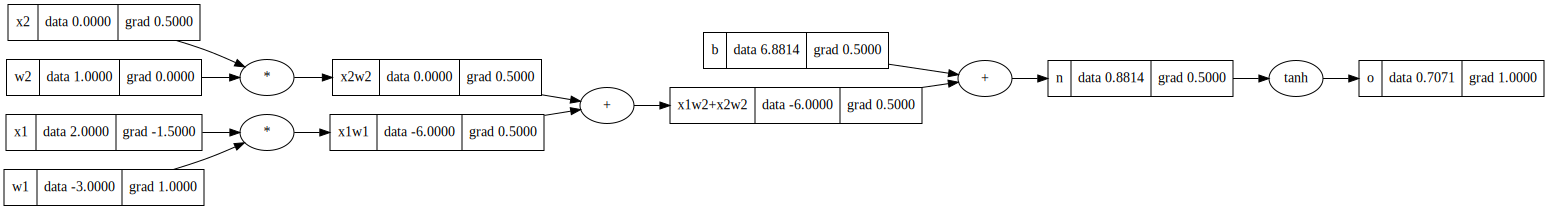

In [8]:
#@title Test case using tanh op
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label="x1w1"
x2w2 = x2 * w2
x2w2.label="x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label="x1w2+x2w2"

n = x1w1x2w2 + b
n.label="n"

o = n.tanh()
o.label="o"


o.backward()
draw_dot(o)

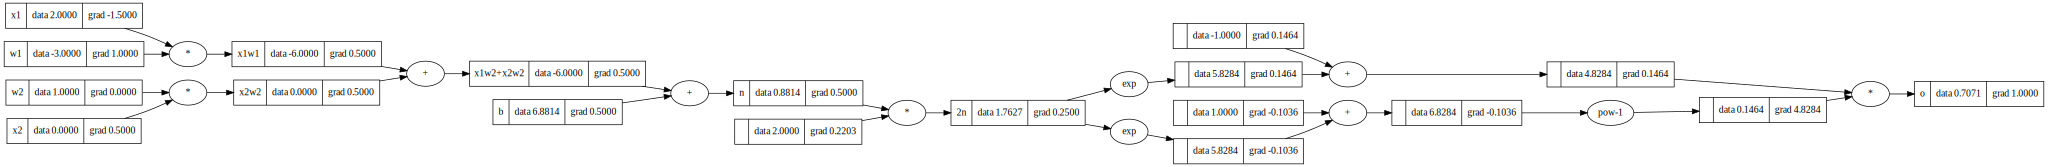

In [9]:
#@title same test case but using more fine-grained op implemented
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label="x1w1"
x2w2 = x2 * w2
x2w2.label="x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label="x1w2+x2w2"

n = x1w1x2w2 + b
n.label="n"
# ------- Not using the tanh impl but more fain-grained op: exp, sub, truediv---
# Results should be the same as using tanh direclty
# o = n.tanh()
two_n = n * 2; two_n.label = "2n"

o = (two_n.exp() - 1) / (two_n.exp() + 1)
o.label="o"
# ------


o.backward()
draw_dot(o)

In [10]:
#@title Topological sort impl for the backward() function on Value class
topo = []
visited = set()
def _build_nodes(node):
  if node in visited:
    return

  visited.add(node)
  for each in node._prev:
    _build_nodes(each)
  topo.append(node)

_build_nodes(o)

topo

[Value=(data=2.0, op=, label=x1),
 Value=(data=-3.0, op=, label=w1),
 Value=(data=-6.0, op=*, label=x1w1),
 Value=(data=0.0, op=, label=x2),
 Value=(data=1.0, op=, label=w2),
 Value=(data=0.0, op=*, label=x2w2),
 Value=(data=-6.0, op=+, label=x1w2+x2w2),
 Value=(data=6.881373587019543, op=, label=b),
 Value=(data=0.8813735870195432, op=+, label=n),
 Value=(data=2, op=, label=),
 Value=(data=1.7627471740390863, op=*, label=2n),
 Value=(data=5.828427124746192, op=exp, label=),
 Value=(data=-1, op=, label=),
 Value=(data=4.828427124746192, op=+, label=),
 Value=(data=5.828427124746192, op=exp, label=),
 Value=(data=1, op=, label=),
 Value=(data=6.828427124746192, op=+, label=),
 Value=(data=0.1464466094067262, op=pow-1, label=),
 Value=(data=0.7071067811865477, op=*, label=o)]

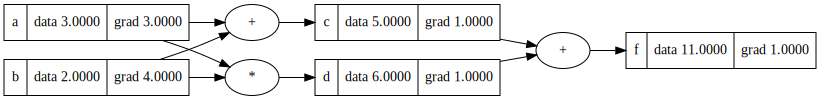

In [11]:
#@title Test case exposing the bug in original impl where the grad needs to be accumulated instead of overriding
a = Value(3.0, label='a')
b = Value(2.0, label='b')

c = a + b
c.label = 'c'

d = a * b
d.label = 'd'

f = c + d
f.label = 'f'


f.backward()
draw_dot(f)

In [12]:
a = Value(3.0, label='a')
# b = 1 + a
b = a**-1
b

Value=(data=0.3333333333333333, op=pow-1, label=)

In [13]:
a = Value(1.0, label='a')
b = Value(0.5, label='b')
a - b

Value=(data=0.5, op=+, label=)

In [14]:
#@title Pytorch version
import torch

# Explicitly casting to double precision, by default it creates float32
# precision

x1 = torch.Tensor([2.0]).double()
# By default Pytorch set leaf node's requires_grad to be False for efficiency.
x1.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

# Forward pass output same, expected to be 0.707106....
print(f'o = {o.item()}')

# Gradient result should be the same as our micro grad impl
print(f'x1 grad = {x1.grad.item()}')
print(f'w1 grad = {w1.grad.item()}')
print(f'x2 grad = {x2.grad.item()}')
print(f'w2 grad = {w2.grad.item()}')
print(f'b grad = {b.grad.item()}')

o = 0.7071066904050358
x1 grad = -1.5000003851533106
w1 grad = 1.0000002567688737
x2 grad = 0.5000001283844369
w2 grad = 0.0
b grad = 0.5000001283844369


n(x) = Value=(data=0.7007128045550626, op=tanh, label=)
layer(x) = [Value=(data=-0.9726724496637805, op=tanh, label=), Value=(data=-0.5777525144440172, op=tanh, label=), Value=(data=-0.9505454327099213, op=tanh, label=)]


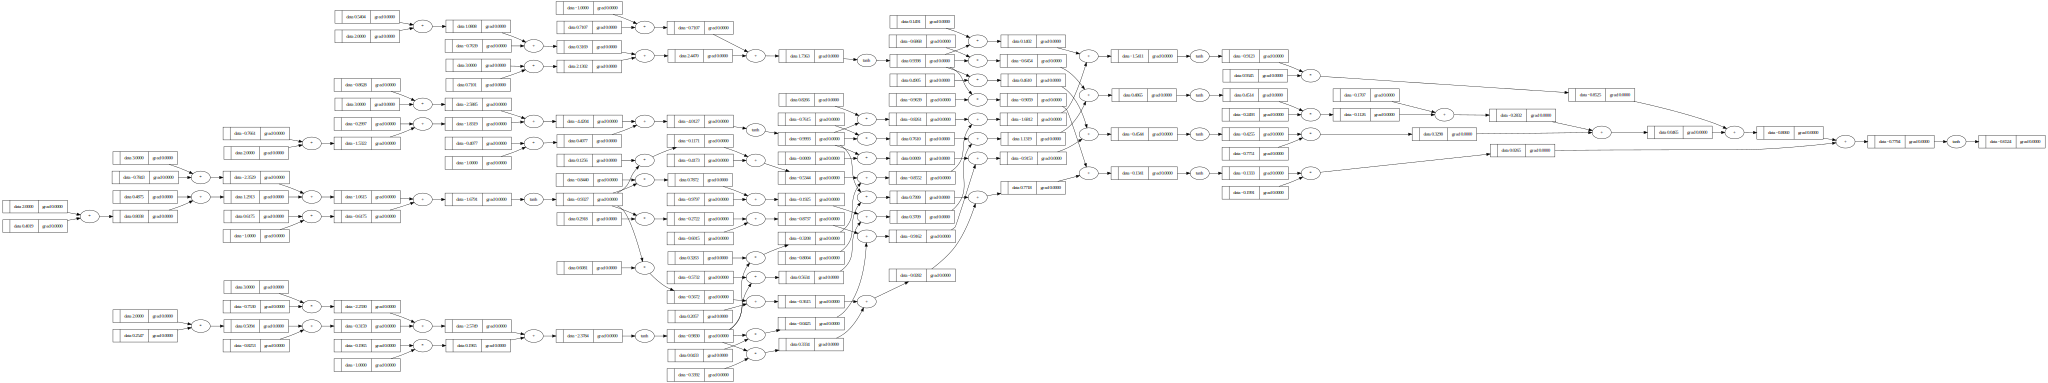

In [23]:
#@title Neuron class and Layer class implementations
import random

class Neuron:
  def __init__(self, nin):
    """Init given nin, which is the dimension/number of inputs."""
    self.w = [Value(random.uniform(-1.0, 1.0)) for _ in range(nin)]
    self.b = Value(random.uniform(-1.0, 1.0))

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self) -> str:
    return f"Neuron w={self.w}, b={self.b}"

  def __call__(self, x):
    # impl wx + b
    assert len(self.w) == len(x), "expect w and x to be of same size"
    # OPTIMIZATION: sum could take an extra param as the `start` param, so we can put b here
    # act = sum(wi * xi for xi, wi in zip(x, self.w)) + self.b
    act = sum((wi*xi for xi, wi in zip(x, self.w)), self.b)
    out = act.tanh()
    return out

# Each layer could contain multiple Neurons
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin=nin) for _ in range(nout)]

  def __repr__(self) -> str:
    return '\n'.join([f"{neuron}" for neuron in self.neurons])

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

class MLP:
  def __init__(self, nin, nout):
    """nin: integer, dimension of inputs
       nout: array of ints representing # of layers
    """
    self.size = [nin] + nout
    self.layers = [Layer(nin=self.size[i], nout=self.size[i+1]) for i in range(len(nout))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x[0]

  def parameters(self):
    params = []
    for layer in self.layers:
      params.extend(layer.parameters())
    return params


# Test Neoron class
x = [2.0, 3.0, -1.0]
n = Neuron(3)
print(f'n(x) = {n(x)}')


# Test Layer class
layer = Layer(nin=3, nout=3)
l = layer(x)
print(f'layer(x) = {l}')

# Test MLP class

mlp = MLP(nin=3, nout=[4,4,1])
out = mlp(x)
# print(f'mlp(x) = {out}')
draw_dot(out)

In [156]:
#@title test datatset on MLP training

# Input data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Target labels
ys = [1.0, -1.0, -1.0, 1.0]

# Create a Neuro net
mlp = MLP(nin=3, nout=[4,4,1])

In [157]:
num_iters = 20
lr = 0.1
losses = []

for i in range(num_iters):
  # Step-1: forward pass
  ypred = [mlp(x) for x in xs]
  # Loss function: mean squared error
  loss = sum((yout - ylabel)**2 for yout, ylabel in zip(ypred, ys))
  losses.append(loss)
  print(f'loss = {loss.data:.5f}')

  # Step-2 backward pass
  # Important: clear up the accumulated grads from previous run first
  for p in mlp.parameters():
    p.grad = 0.0

  loss.backward()

  # Step-3: Update parameters using gradient descent
  for p in mlp.parameters():
    p.data += -lr * p.grad

loss = 6.61034
loss = 4.06235
loss = 4.37836
loss = 4.68973
loss = 4.49408
loss = 3.11364
loss = 1.22079
loss = 0.83337
loss = 0.57957
loss = 0.32312
loss = 0.12818
loss = 0.09822
loss = 0.08166
loss = 0.06969
loss = 0.06061
loss = 0.05350
loss = 0.04779
loss = 0.04313
loss = 0.03925
loss = 0.03598
